<a href="https://colab.research.google.com/github/pranay236/pranay236/blob/main/food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-16 19:04:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-16 19:04:15 (89.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                    split=["train","validation"],
                                    shuffle_files=True,
                                    as_supervised=True,
                                    with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteO5T1QU/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteO5T1QU/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
len(class_names)

101

In [ ]:
train_one_sample = train_data.take(1)

In [ ]:
for image,label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from food101: {label}
  class name : {class_names[label.numpy()]}""")


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from food101: 1
  class name : baby_back_ribs


(-0.5, 511.5, 511.5, -0.5)

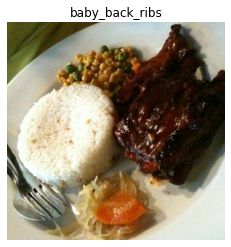

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [ ]:
import tensorflow as tf
def preprocess_image(image,label,img_shape=224):
  image = tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label

In [ ]:
preprocess_image(image,label)[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 88.755104,  88.755104,  18.755102],
        [ 88.341835,  85.341835,  18.341835],
        [ 86.377556,  81.16327 ,  17.591837],
        ...,
        [182.5153  , 193.5153  , 195.5153  ],
        [181.47958 , 192.47958 , 194.47958 ],
        [181.39784 , 192.39784 , 194.39784 ]],

       [[ 96.57143 ,  93.57143 ,  24.571428],
        [ 92.38265 ,  89.38265 ,  22.382656],
        [ 93.72959 ,  88.515305,  24.94388 ],
        ...,
        [189.42863 , 200.42863 , 202.42863 ],
        [189.78568 , 200.78568 , 202.78568 ],
        [183.90295 , 197.90295 , 198.90295 ]],

       [[ 90.22959 ,  87.22959 ,  18.658163],
        [100.89286 ,  97.46429 ,  30.678574],
        [ 96.821434,  91.515305,  27.943878],
        ...,
        [186.55103 , 200.04597 , 201.55107 ],
        [182.96938 , 197.18367 , 200.18367 ],
        [186.21425 , 200.42854 , 203.42854 ]],

       ...,

       [[207.35211 , 197.13785 , 162.78064 ],
        [204.

In [ ]:
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                               monitor="val_loss",
                                               save_best_only=True,
                                               save_weights_only=True,
                                               verbose=0)

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
from tensorflow.keras import layers

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

inputs = layers.Input(shape=input_shape,name="input_layer")
x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names),name="output_layer")(x)
outputs = layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
history = model.fit(train_data,epochs=3,
                steps_per_epoch=len(train_data),
                validation_data=test_data,
                validation_steps = int(0.15 * len(test_data)),
                callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                           model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230316-192939
Epoch 1/3
2368/2368 [==============================] - 204s 79ms/step - loss: 1.7177 - accuracy: 0.5818 - val_loss: 1.1299 - val_accuracy: 0.7018
Epoch 2/3
2368/2368 [==============================] - 193s 81ms/step - loss: 1.2000 - accuracy: 0.6880 - val_loss: 1.0336 - val_accuracy: 0.7217
Epoch 3/3
2368/2368 [==============================] - 198s 83ms/step - loss: 1.0549 - accuracy: 0.7241 - val_loss: 0.9973 - val_accuracy: 0.7259


In [ ]:
testing_eval = model.evaluate(test_data)
testing_eval

790/790 [==============================] - 54s 68ms/step - loss: 0.9988 - accuracy: 0.7256


[0.9988288283348083, 0.7256237864494324]

In [ ]:
model.save("saved_model/my_model")